# Purpose of tis Notebook

This notebook is used for training the test models. It inputs numpy arrays that are extracted by extract_arrays.ipynb. tHe paths to these should be entered in the FEATURES_PATH and LABELS_PATH variables.

The notebook trains the models and print the evaluate results. It also saves the models for reuse. 




In [1]:
import os
import pandas as pd
import tensorflow as tf
import numpy as np
import datetime as dt
from tensorflow import keras
from tensorflow.keras import layers, callbacks
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from matplotlib import pyplot as plt

In [2]:
FEATURES_PATH = "data/my_20_sec_features-2022_05_26__19_44_46.npy"
LABELS_PATH = "data/my_20_sec_labels-2022_05_26__19_44_46.npy"

SEED = 42

In [3]:
with open(FEATURES_PATH, 'rb') as f:
    features = np.load(f)
features.shape

(3000, 200, 150, 2)

In [4]:
with open(LABELS_PATH, 'rb') as f:
    labels = np.load(f)
labels.shape

(3000,)

In [5]:
labels = [label.split('-')[0] for label in labels]
labels[:10]

['www.youtube.com',
 'www.bbc.co.uk',
 'www.facebook.com',
 'www.twitter.com',
 'www.wikipedia.com',
 'www.ebay.co.uk',
 'www.google.com',
 'www.google.com',
 'www.bbc.co.uk',
 'www.ebay.co.uk']

In [6]:
label_binariser = LabelBinarizer()
labels_encoded = label_binariser.fit_transform(labels)
labels_encoded.shape

(3000, 10)

In [7]:
cnn = keras.Sequential()

cnn.add(layers.InputLayer((200,150,2)))
cnn.add(layers.Conv2D(filters=10, kernel_size=(3,3)))
# cnn.add(layers.MaxPool2D(pool_size=(2,2), padding = 'same', data_format = "channels_last"))
cnn.add(layers.Conv2D(filters=24, kernel_size=(3,3)))
# cnn.add(layers.MaxPool2D(pool_size=(2,2), padding = 'same', data_format = "channels_last"))
cnn.add(layers.Conv2D(filters=32, kernel_size=(3,3)))
cnn.add(layers.Flatten())
cnn.add(layers.Dense(64, activation="relu"))
cnn.add(layers.Dense(labels_encoded.shape[1], activation="softmax"))

cnn.summary()

2022-08-15 13:02:53.478247: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 198, 148, 10)      190       
                                                                 
 conv2d_1 (Conv2D)           (None, 196, 146, 24)      2184      
                                                                 
 conv2d_2 (Conv2D)           (None, 194, 144, 32)      6944      
                                                                 
 flatten (Flatten)           (None, 893952)            0         
                                                                 
 dense (Dense)               (None, 64)                57212992  
                                                                 
 dense_1 (Dense)             (None, 10)                650       
                                                                 
Total params: 57,222,960
Trainable params: 57,222,960
No

In [8]:
features_train, features_test, labels_train, labels_test = train_test_split(features, labels_encoded,
    test_size=0.25,
    shuffle=True,
    random_state=SEED
)

In [9]:
max = features_train.max()

features_train = features_train/max
features_test = features_test/max

print(max)

709.0


In [10]:
early_stopping_callback = callbacks.EarlyStopping(monitor='val_loss', patience=10, mode='min', restore_best_weights=True)

In [11]:
opt = tf.keras.optimizers.Adam(learning_rate=1)
cnn.compile(optimizer=opt, loss="categorical_crossentropy", metrics=["accuracy"])
cnn_history = cnn.fit(features_train, labels_train, epochs=50, batch_size=16, validation_split=0.2, callbacks=[early_stopping_callback])

Epoch 1/50
113/113 [==============================] - 57s 494ms/step - loss: 15116243968.0000 - accuracy: 0.1100 - val_loss: 2.3598 - val_accuracy: 0.1200
Epoch 2/50
113/113 [==============================] - 55s 490ms/step - loss: 2.3935 - accuracy: 0.0967 - val_loss: 2.3667 - val_accuracy: 0.1089
Epoch 3/50
113/113 [==============================] - 56s 492ms/step - loss: 2.4208 - accuracy: 0.1028 - val_loss: 2.4249 - val_accuracy: 0.1133
Epoch 4/50
113/113 [==============================] - 58s 514ms/step - loss: 2.3961 - accuracy: 0.0989 - val_loss: 2.5456 - val_accuracy: 0.0911
Epoch 5/50
113/113 [==============================] - 60s 533ms/step - loss: 2.4567 - accuracy: 0.1022 - val_loss: 2.3907 - val_accuracy: 0.1000
Epoch 6/50
113/113 [==============================] - 59s 526ms/step - loss: 2.4645 - accuracy: 0.1050 - val_loss: 2.3857 - val_accuracy: 0.1133
Epoch 7/50
113/113 [==============================] - 59s 526ms/step - loss: 2.4317 - accuracy: 0.1089 - val_loss: 2.536

In [12]:
cnn.evaluate(features_test, labels_test)

24/24 [==============================] - 4s 175ms/step - loss: 2.3915 - accuracy: 0.1053


[2.3914620876312256, 0.10533333569765091]

In [13]:
def plot_history(history):
    fig, axs = plt.subplots(1, 2, figsize=(10,5)) 
    (ax1, ax2) = axs
    ax1.plot(history.history['loss'], label='train')
    ax1.plot(history.history['val_loss'], label='validation')

    ax1.legend(loc="upper right")
    ax1.set_xlabel("# of epochs")
    ax1.set_ylabel("loss")

    ax2.plot(history.history['accuracy'], label='train')
    ax2.plot(history.history['val_accuracy'], label='validation')

    ax2.legend(loc="upper right")
    ax2.set_xlabel("# of epochs")
    ax2.set_ylabel("accuracy")

    print("Final training accuracy:", history.history['accuracy'][-1])
    print("Final validation accuracy:", history.history['val_accuracy'][-1])

Final training accuracy: 0.08777777850627899
Final validation accuracy: 0.11555555462837219


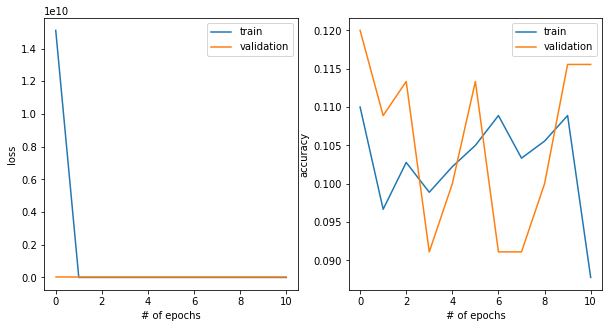

In [14]:
plot_history(cnn_history)

In [15]:
def plot_results(model):
    predictions =  model.predict(features_test)
    cm = confusion_matrix(labels_test, predictions, labels=model.classes_, normalize='true')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_binariser.inverse_transform(model.classes_))
    disp.plot(xticks_rotation=270, values_format=".1f")
    plt.show()
    print(classification_report(labels_test, predictions))

    # Unsure this is needed as over written in a few cells.

In [16]:
y_true = np.argmax(labels_test, axis=1)
unique_y = np.unique(y_true)

In [17]:
predictions =  np.argmax(cnn.predict(features_test), axis=1)

In [18]:
def plot_results(model):
    fig, ax = plt.subplots(figsize=(12, 12))
    y_true = np.argmax(labels_test, axis=1)
    predictions =  np.argmax(model.predict(features_test), axis=1)
    cm = confusion_matrix(y_true, predictions, normalize='true')
    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm,
        display_labels=[label_binariser.classes_[x] for x in range(unique_y.min(), len(unique_y))]
        )
    disp.plot(xticks_rotation=270, values_format=".1f", ax=ax)
    plt.show()
    print(classification_report(y_true, predictions))

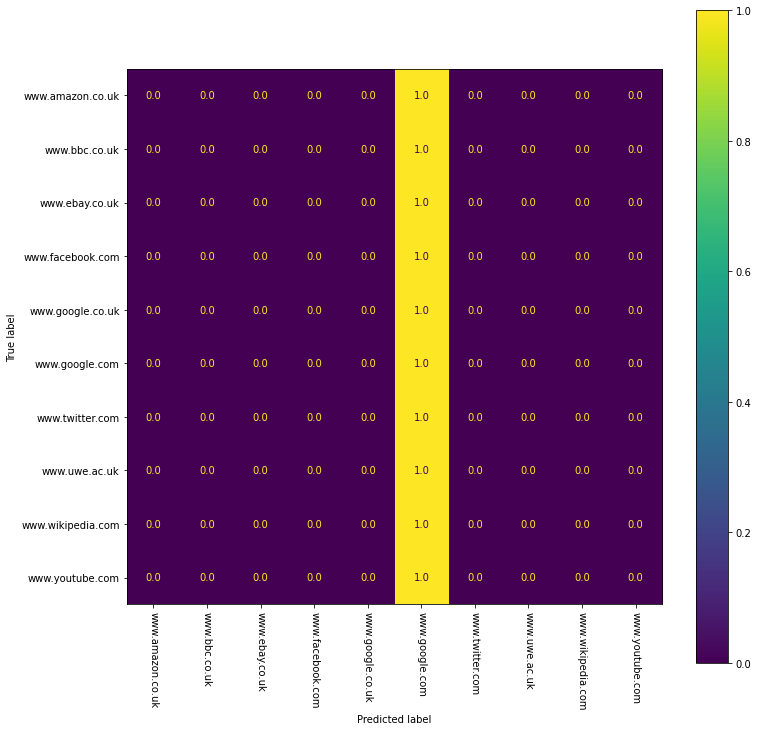

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        81
           1       0.00      0.00      0.00        63
           2       0.00      0.00      0.00        73
           3       0.00      0.00      0.00        79
           4       0.00      0.00      0.00        65
           5       0.11      1.00      0.19        79
           6       0.00      0.00      0.00        76
           7       0.00      0.00      0.00        68
           8       0.00      0.00      0.00        84
           9       0.00      0.00      0.00        82

    accuracy                           0.11       750
   macro avg       0.01      0.10      0.02       750
weighted avg       0.01      0.11      0.02       750



/Users/michaelkearney/.local/share/virtualenvs/UNB_Datasets-qeLdalLc/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/michaelkearney/.local/share/virtualenvs/UNB_Datasets-qeLdalLc/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/michaelkearney/.local/share/virtualenvs/UNB_Datasets-qeLdalLc/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use 

In [19]:
plot_results(cnn)

In [20]:
def create_convlstm_model():

    model = keras.Sequential()

    model.add(layers.ConvLSTM1D(
        filters = 4,
        kernel_size=5,
        activation="tanh",
        data_format="channels_last",
        recurrent_dropout=0.2,
        return_sequences=True,
        input_shape = (features_train[0].shape)
    ))

    model.add(layers.MaxPooling2D(
        pool_size = (1, 2),
        padding = 'same',
        data_format = "channels_last"
    ))

    model.add(layers.TimeDistributed(layers.Dropout(0.2)))
    # Dropout layer for sequence data



    model.add(layers.ConvLSTM1D(
        filters=10,
        kernel_size=15,
        activation="tanh",
        data_format="channels_last",
        recurrent_dropout=0.2,
        return_sequences=True
    ))

    model.add(layers.MaxPooling2D(
        pool_size = (1, 2),
        padding = 'same',
        data_format = "channels_last"
    ))

    model.add(layers.TimeDistributed(layers.Dropout(0.2)))


    model.add(layers.ConvLSTM1D(
        filters=14,
        kernel_size=10,
        activation="tanh",
        data_format="channels_last",
        recurrent_dropout=0.2,
        return_sequences=True
    ))

    model.add(layers.MaxPooling2D(
        pool_size = (1, 2),
        padding = 'same',
        data_format = "channels_last"
    ))

    model.add(layers.TimeDistributed(layers.Dropout(0.2)))


    model.add(layers.ConvLSTM1D(
        filters=16,
        kernel_size=10,
        activation="tanh",
        data_format="channels_last",
        recurrent_dropout=0.2,
        return_sequences=True
    ))

    model.add(layers.MaxPooling2D(
        pool_size = (1, 2),
        padding = 'same',
        data_format = "channels_last"
    ))

    # model.add(TimeDistributed(Dropout(0.2)))


    model.add(layers.Flatten())

    model.add(layers.Dense(128, activation="relu"))
    
    model.add(layers.Dense(labels_encoded.shape[1], activation="softmax"))

    model.summary()

    return model

In [21]:
convlstm_model = create_convlstm_model()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm1d (ConvLSTM1D)    (None, 200, 146, 4)       496       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 200, 73, 4)       0         
 )                                                               
                                                                 
 time_distributed (TimeDistr  (None, 200, 73, 4)       0         
 ibuted)                                                         
                                                                 
 conv_lstm1d_1 (ConvLSTM1D)  (None, 200, 59, 10)       8440      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 200, 30, 10)      0         
 2D)                                                             
                                                      

In [22]:
convlstm_model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
convlstm_history = convlstm_model.fit(x=features_train, y=labels_train, epochs=50, batch_size=16, shuffle=True, validation_split=0.2, callbacks=[early_stopping_callback])

Epoch 1/50
113/113 [==============================] - 371s 3s/step - loss: 2.0854 - accuracy: 0.1950 - val_loss: 1.8332 - val_accuracy: 0.1622
Epoch 2/50
113/113 [==============================] - 369s 3s/step - loss: 1.3426 - accuracy: 0.4161 - val_loss: 1.1147 - val_accuracy: 0.5800
Epoch 3/50
113/113 [==============================] - 374s 3s/step - loss: 1.0916 - accuracy: 0.5383 - val_loss: 1.0106 - val_accuracy: 0.4889
Epoch 4/50
113/113 [==============================] - 381s 3s/step - loss: 0.8636 - accuracy: 0.6533 - val_loss: 0.5666 - val_accuracy: 0.7400
Epoch 5/50
113/113 [==============================] - 390s 3s/step - loss: 0.8161 - accuracy: 0.6644 - val_loss: 0.5411 - val_accuracy: 0.8044
Epoch 6/50
113/113 [==============================] - 388s 3s/step - loss: 0.6514 - accuracy: 0.7150 - val_loss: 0.3743 - val_accuracy: 0.8644
Epoch 7/50
113/113 [==============================] - 379s 3s/step - loss: 0.6639 - accuracy: 0.7106 - val_loss: 0.4096 - val_accuracy: 0.8422

Final training accuracy: 0.9477777481079102
Final validation accuracy: 0.9599999785423279


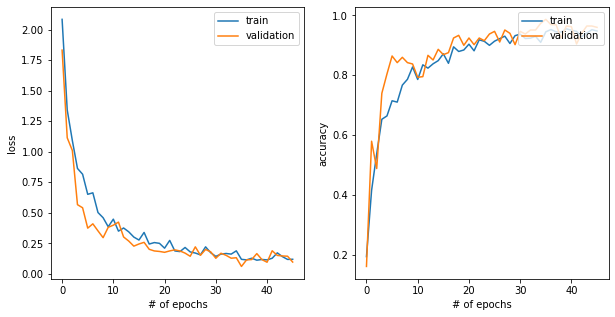

In [23]:
plot_history(convlstm_history)

In [24]:
model_evaluation_history = convlstm_model.evaluate(features_test, labels_test)
loss, acc = model_evaluation_history
date_time_format = '%Y_%m_%d__%H_%M_%S'
current_datetime = dt.datetime.now()
current_datetime_string = dt.datetime.strftime(current_datetime, date_time_format)
model_file_name =f"convlstm_model_Datetime_{current_datetime_string}__loss_{loss}_acc_{acc}.h5"
convlstm_model.save(os.path.join("models", model_file_name))

24/24 [==============================] - 8s 323ms/step - loss: 0.0965 - accuracy: 0.9773


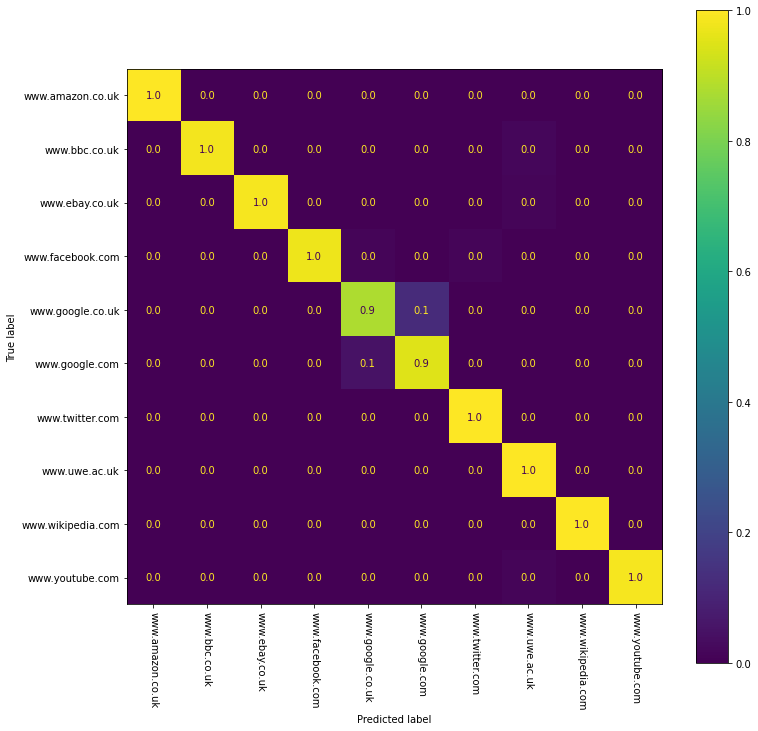

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        81
           1       1.00      0.98      0.99        63
           2       1.00      0.99      0.99        73
           3       1.00      0.97      0.99        79
           4       0.92      0.88      0.90        65
           5       0.90      0.95      0.93        79
           6       0.99      1.00      0.99        76
           7       0.96      1.00      0.98        68
           8       1.00      1.00      1.00        84
           9       1.00      0.99      0.99        82

    accuracy                           0.98       750
   macro avg       0.98      0.98      0.98       750
weighted avg       0.98      0.98      0.98       750



In [25]:
plot_results(convlstm_model)

In [26]:
def create_lrcn_model():

    model = keras.Sequential()

    model.add(
        layers.TimeDistributed(
            layers.Conv1D(
                filters=16,
                kernel_size=3,
                padding="same",
                activation="relu"
            ),
        input_shape=(features_train[0].shape)
        )
    )
  
    model.add(
        layers.TimeDistributed(
            layers.Dropout(0.25)
        )
    )

    model.add(
        layers.TimeDistributed(
            layers.Conv1D(
                filters=32,
                kernel_size=3,
                padding="same",
                activation="relu"
            )
        )
    )

    model.add(
        layers.TimeDistributed(
            layers.Dropout(0.25)
        )
    )

    model.add(
        layers.TimeDistributed(
            layers.Conv1D(
                filters=64,
                kernel_size=3,
                padding="same",
                activation="relu"
            )
        )
    )

    model.add(
        layers.TimeDistributed(
            layers.Dropout(0.25)
        )
    )

    model.add(
        layers.TimeDistributed(
            layers.Conv1D(
                filters=64,
                kernel_size=3,
                padding="same",
                activation="relu"
            )
        )
    )

    model.add(
        layers.TimeDistributed(
            layers.Flatten()
        )
    )

    model.add(
        layers.LSTM(32)
    )

    model.add(
        layers.Dense(
            labels_encoded.shape[1],
            activation="softmax"
        )
    )

    model.summary()

    return model

In [27]:
lrcn_model = create_lrcn_model()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_3 (TimeDis  (None, 200, 150, 16)     112       
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 200, 150, 16)     0         
 tributed)                                                       
                                                                 
 time_distributed_5 (TimeDis  (None, 200, 150, 32)     1568      
 tributed)                                                       
                                                                 
 time_distributed_6 (TimeDis  (None, 200, 150, 32)     0         
 tributed)                                                       
                                                                 
 time_distributed_7 (TimeDis  (None, 200, 150, 64)    

In [28]:
lrcn_model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
lrcn_history = lrcn_model.fit(x=features_train, y=labels_train, epochs=30, batch_size=16, shuffle=True, validation_split=0.2, callbacks=[early_stopping_callback])

Epoch 1/30
113/113 [==============================] - 189s 2s/step - loss: 2.3031 - accuracy: 0.1117 - val_loss: 2.3047 - val_accuracy: 0.0822
Epoch 2/30
113/113 [==============================] - 187s 2s/step - loss: 2.3022 - accuracy: 0.1194 - val_loss: 2.3059 - val_accuracy: 0.0822
Epoch 3/30
113/113 [==============================] - 187s 2s/step - loss: 2.3015 - accuracy: 0.1194 - val_loss: 2.3056 - val_accuracy: 0.0822
Epoch 4/30
113/113 [==============================] - 188s 2s/step - loss: 2.3015 - accuracy: 0.1194 - val_loss: 2.3074 - val_accuracy: 0.0822
Epoch 5/30
113/113 [==============================] - 188s 2s/step - loss: 2.3015 - accuracy: 0.1194 - val_loss: 2.3054 - val_accuracy: 0.0822
Epoch 6/30
113/113 [==============================] - 189s 2s/step - loss: 2.3020 - accuracy: 0.1194 - val_loss: 2.3058 - val_accuracy: 0.0822
Epoch 7/30
113/113 [==============================] - 189s 2s/step - loss: 2.3011 - accuracy: 0.1194 - val_loss: 2.3067 - val_accuracy: 0.0822

In [29]:
model_evaluation_history = lrcn_model.evaluate(features_test, labels_test)

24/24 [==============================] - 11s 454ms/step - loss: 2.3037 - accuracy: 0.0907


Final training accuracy: 0.11944444477558136
Final validation accuracy: 0.08222222328186035


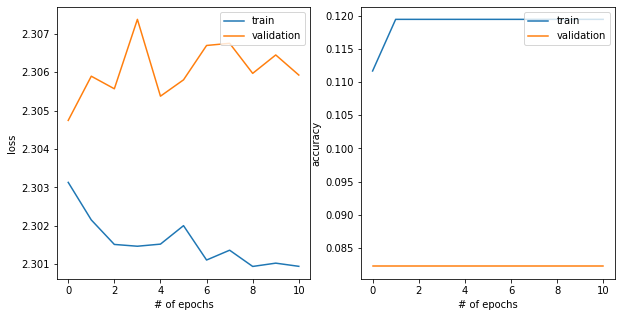

In [30]:
plot_history(lrcn_history)

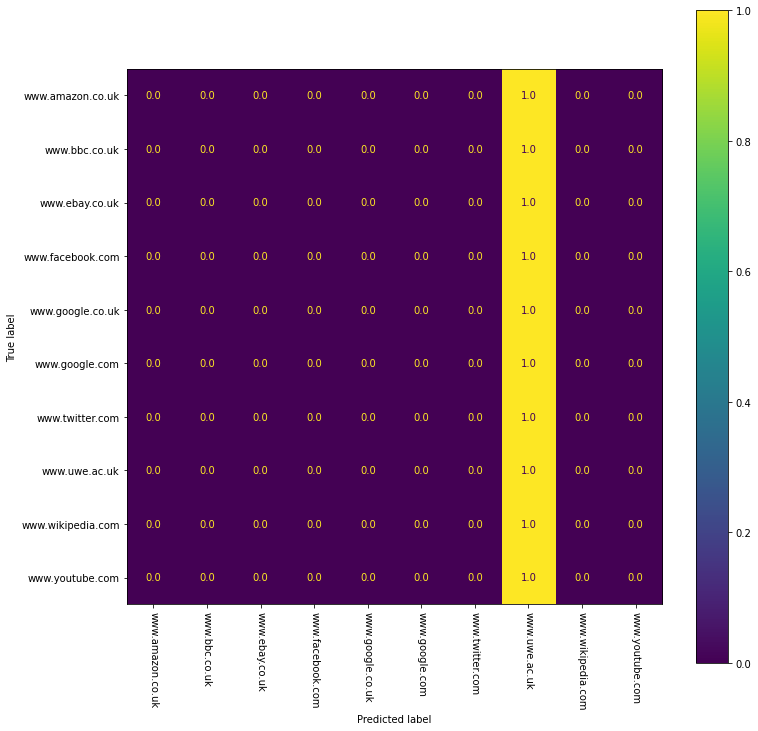

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        81
           1       0.00      0.00      0.00        63
           2       0.00      0.00      0.00        73
           3       0.00      0.00      0.00        79
           4       0.00      0.00      0.00        65
           5       0.00      0.00      0.00        79
           6       0.00      0.00      0.00        76
           7       0.09      1.00      0.17        68
           8       0.00      0.00      0.00        84
           9       0.00      0.00      0.00        82

    accuracy                           0.09       750
   macro avg       0.01      0.10      0.02       750
weighted avg       0.01      0.09      0.02       750



/Users/michaelkearney/.local/share/virtualenvs/UNB_Datasets-qeLdalLc/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/michaelkearney/.local/share/virtualenvs/UNB_Datasets-qeLdalLc/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/michaelkearney/.local/share/virtualenvs/UNB_Datasets-qeLdalLc/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use 

In [31]:
plot_results(lrcn_model)